In [2]:
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import time

DATASET_PATH = kagglehub.dataset_download("prasadvpatil/mrl-dataset/versions/3")
TRAIN_DIR = os.path.join(DATASET_PATH, "train")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

c:\Users\GN\anaconda3\envs\computer_vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Load Test Dataset

In [3]:
classes = sorted(os.listdir(TRAIN_DIR)) 
all_image_paths = []
all_labels = []
all_subject_ids = []

for label_idx, label in enumerate(classes):
    class_dir = os.path.join(TRAIN_DIR, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(class_dir, img_file)
            all_image_paths.append(full_path)
            all_labels.append(label_idx)
            
            filename = os.path.basename(img_file)
            subject_id = filename.split('_')[0] 
            all_subject_ids.append(subject_id)

df = pd.DataFrame({
    'path': all_image_paths,
    'label': all_labels,
    'subject_id': all_subject_ids
})

TEST_SPLIT = 0.15
splitter_test = GroupShuffleSplit(test_size=TEST_SPLIT, n_splits=1, random_state=42)
trainval_idxs, test_idxs = next(splitter_test.split(df, groups=df['subject_id']))

test_df = df.iloc[test_idxs]
test_paths = test_df['path'].tolist()
test_labels = test_df['label'].tolist()

print(f"Test Subjects: {test_df['subject_id'].nunique()}")
print(f"Test images: {len(test_df)}")
print(f"Classes: {classes}")

Test Subjects: 3
Test images: 2725
Classes: ['Closed_Eyes', 'Open_Eyes']


## Define Model Architectures

In [4]:
class CNN(nn.Module):
    def __init__(self, img_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(p=0.6),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

def create_mobilenet_model(num_classes=2, dropout=0.5):
    model = models.mobilenet_v2(weights=None)
    
    for param in model.features[:-3].parameters():
        param.requires_grad = False
    
    in_features = model.classifier[1].in_features
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, num_classes)
    )
    
    return model

print("Model architectures defined")

Model architectures defined


## Dataset Classes for Each Model

In [5]:
class EyeDatasetGrayscale(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class EyeDatasetRGB(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")  
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

mobilenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cnn_test_dataset = EyeDatasetGrayscale(test_paths, test_labels, transform=cnn_transform)
mobilenet_test_dataset = EyeDatasetRGB(test_paths, test_labels, transform=mobilenet_transform)

cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=32, shuffle=False, num_workers=0)
mobilenet_test_loader = DataLoader(mobilenet_test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Datasets created")

Datasets created


## Load Best Models from Cross-Validation

In [ ]:
CNN_PATH = "../outputs/cnn/fold_4_best_model.pth"          
MOBILENET_PATH = "../outputs/mobilenet/fold_5_best_model.pth"

cnn_model = CNN(img_size=64).to(device)
cnn_model.load_state_dict(torch.load(CNN_PATH, map_location=device))
cnn_model.eval()
print(f"Loaded CNN model from {CNN_PATH}")

mobilenet_model = create_mobilenet_model(num_classes=2, dropout=0.5).to(device)
mobilenet_model.load_state_dict(torch.load(MOBILENET_PATH, map_location=device))
mobilenet_model.eval()
print(f"Loaded MobileNet model from {MOBILENET_PATH}")

Loaded CNN model from outputs/cnn_2/fold_4_best_model.pth
Loaded MobileNet model from outputs/mobilenet_2/fold_5_best_model.pth


C:\Users\GN\AppData\Local\Temp\ipykernel_4176\1126315609.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(CNN_PATH, map_location=devi

## Evaluation Function

In [7]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(lbls.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    
    end_time = time.time()
    inference_time = end_time - start_time
    avg_time_per_image = inference_time / len(test_loader.dataset) * 1000  # ms
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    results = {
        'model_name': model_name,
        'y_true': np.array(y_true),
        'y_pred': np.array(y_pred),
        'y_probs': np.array(y_probs),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'inference_time': inference_time,
        'avg_time_per_image': avg_time_per_image
    }
    
    return results

print("Evaluating CNN model...")
cnn_results = evaluate_model(cnn_model, cnn_test_loader, "CNN")

print("Evaluating MobileNetV2 model...")
mobilenet_results = evaluate_model(mobilenet_model, mobilenet_test_loader, "MobileNetV2")

print("Evaluation complete")

Evaluating CNN model...
Evaluating MobileNetV2 model...
Evaluation complete


## Performance Comparison Table

In [8]:
comparison_df = pd.DataFrame({
    'Model': ['CNN', 'MobileNetV2'],
    'Accuracy': [cnn_results['accuracy'], mobilenet_results['accuracy']],
    'Precision': [cnn_results['precision'], mobilenet_results['precision']],
    'Recall': [cnn_results['recall'], mobilenet_results['recall']],
    'F1-Score': [cnn_results['f1'], mobilenet_results['f1']],
    'Total Inference Time (s)': [cnn_results['inference_time'], mobilenet_results['inference_time']],
    'Avg Time per Image (ms)': [cnn_results['avg_time_per_image'], mobilenet_results['avg_time_per_image']]
})

cnn_params = sum(p.numel() for p in cnn_model.parameters())
mobilenet_params = sum(p.numel() for p in mobilenet_model.parameters())
mobilenet_trainable = sum(p.numel() for p in mobilenet_model.parameters() if p.requires_grad)

comparison_df['Total Parameters'] = [cnn_params, mobilenet_params]
comparison_df['Trainable Parameters'] = [cnn_params, mobilenet_trainable]

print("MODEL COMPARISON SUMMARY")
print(comparison_df.to_string(index=False))
print("="*160)

if cnn_results['accuracy'] > mobilenet_results['accuracy']:
    winner = "CNN"
    diff = (cnn_results['accuracy'] - mobilenet_results['accuracy']) * 100
else:
    winner = "MobileNetV2"
    diff = (mobilenet_results['accuracy'] - cnn_results['accuracy']) * 100

print(f"\nBest Model: {winner} (by {diff:.2f}% accuracy)")

MODEL COMPARISON SUMMARY
      Model  Accuracy  Precision   Recall  F1-Score  Total Inference Time (s)  Avg Time per Image (ms)  Total Parameters  Trainable Parameters
        CNN  0.934312   0.943987 0.934312  0.935575                  1.467618                 0.538575           1142082               1142082
MobileNetV2  0.974679   0.976512 0.974679  0.974913                  5.515333                 2.023975           2388354               1370562

Best Model: MobileNetV2 (by 4.04% accuracy)


## Confusion Matrices Comparison

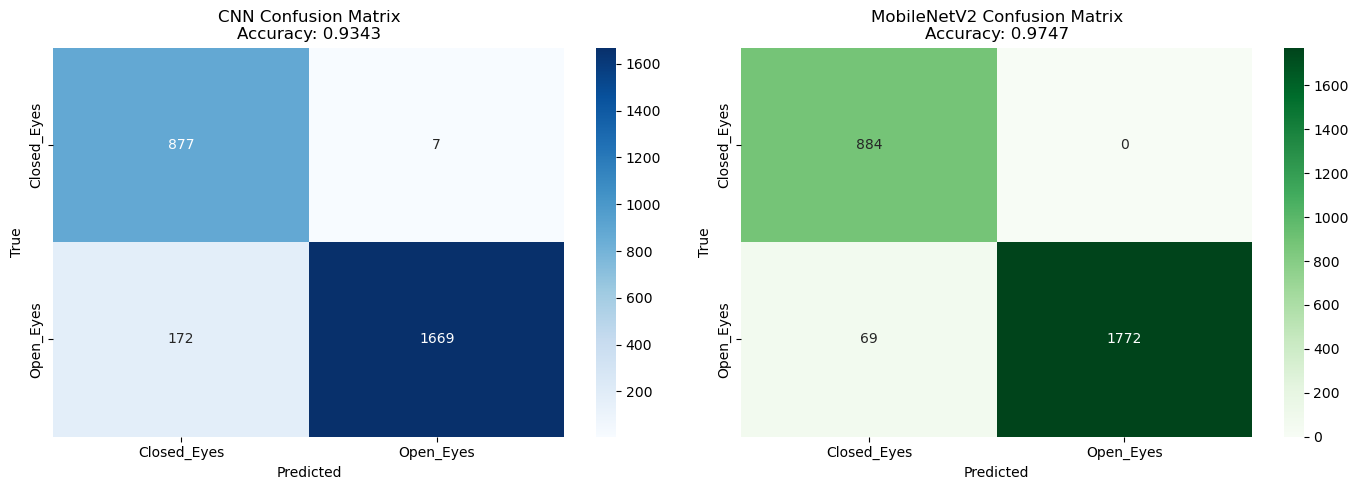

Confusion matrices saved to outputs/confusion_matrices_comparison.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_cnn = confusion_matrix(cnn_results['y_true'], cnn_results['y_pred'])
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title(f"CNN Confusion Matrix\nAccuracy: {cnn_results['accuracy']:.4f}")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

cm_mobilenet = confusion_matrix(mobilenet_results['y_true'], mobilenet_results['y_pred'])
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title(f"MobileNetV2 Confusion Matrix\nAccuracy: {mobilenet_results['accuracy']:.4f}")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('../outputs/confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved to ../outputs/confusion_matrices_comparison.png")

## Detailed Classification Reports

In [10]:
print("="*80)
print("CNN MODEL - Classification Report")
print("="*80)
print(classification_report(cnn_results['y_true'], cnn_results['y_pred'], 
                          target_names=classes, digits=4))

print("\n" + "="*80)
print("MOBILENETV2 MODEL - Classification Report")
print("="*80)
print(classification_report(mobilenet_results['y_true'], mobilenet_results['y_pred'], 
                          target_names=classes, digits=4))

CNN MODEL - Classification Report
              precision    recall  f1-score   support

 Closed_Eyes     0.8360    0.9921    0.9074       884
   Open_Eyes     0.9958    0.9066    0.9491      1841

    accuracy                         0.9343      2725
   macro avg     0.9159    0.9493    0.9283      2725
weighted avg     0.9440    0.9343    0.9356      2725


MOBILENETV2 MODEL - Classification Report
              precision    recall  f1-score   support

 Closed_Eyes     0.9276    1.0000    0.9624       884
   Open_Eyes     1.0000    0.9625    0.9809      1841

    accuracy                         0.9747      2725
   macro avg     0.9638    0.9813    0.9717      2725
weighted avg     0.9765    0.9747    0.9749      2725



## Performance Metrics Visualization

In [11]:
print("Available keys:", cnn_results.keys())

Available keys: dict_keys(['model_name', 'y_true', 'y_pred', 'y_probs', 'accuracy', 'precision', 'recall', 'f1', 'inference_time', 'avg_time_per_image'])


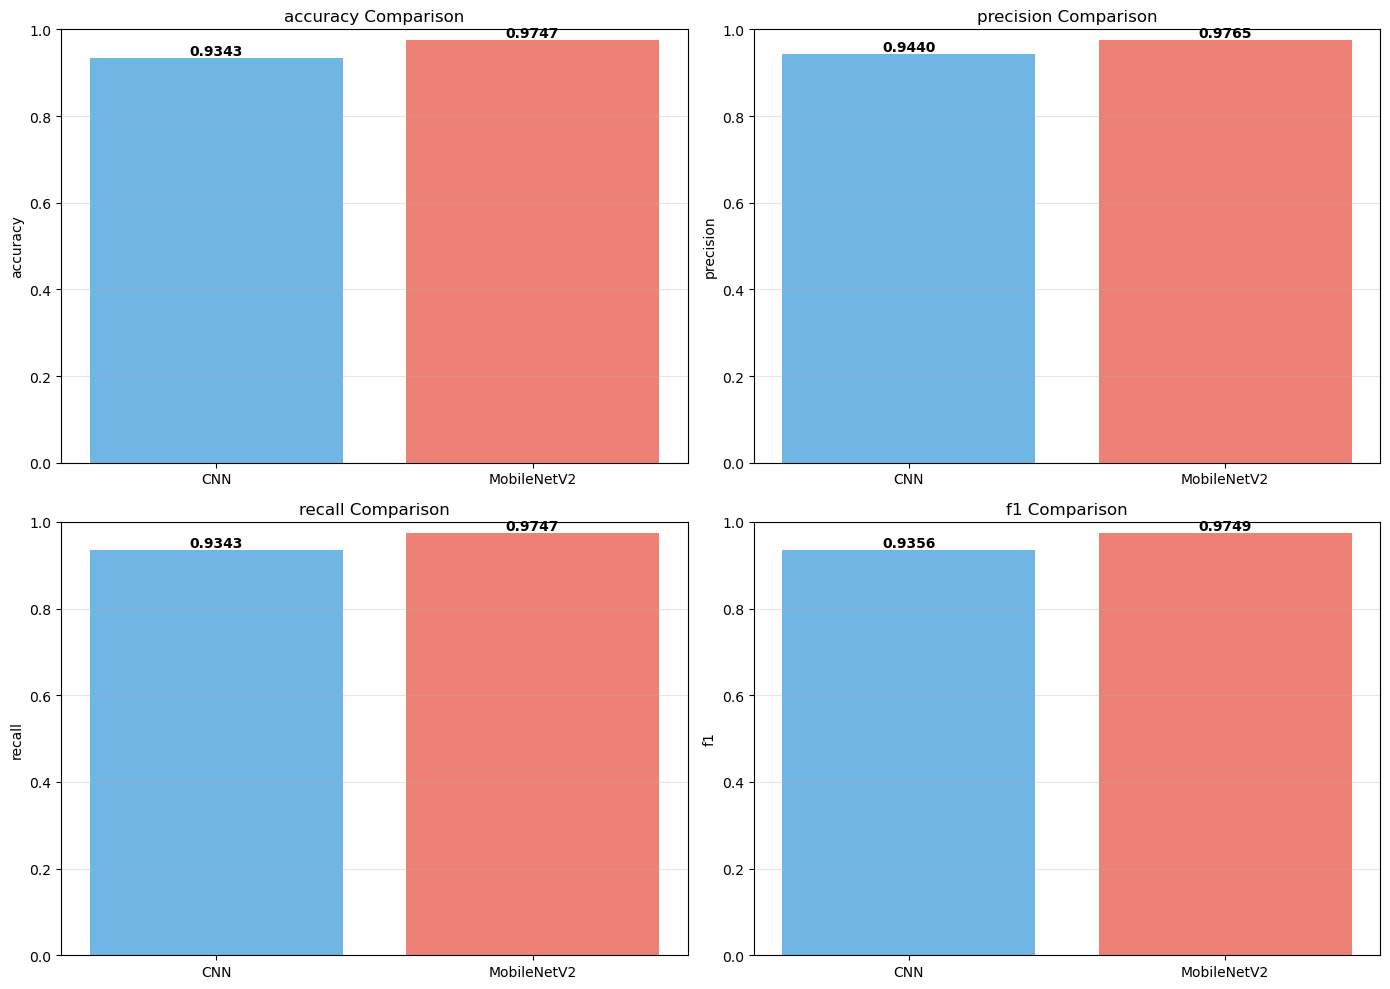

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [cnn_results[metric.lower().replace('-', '_')], 
              mobilenet_results[metric.lower().replace('-', '_')]]
    bars = ax.bar(['CNN', 'MobileNetV2'], values, color=colors, alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Inference Time Comparison

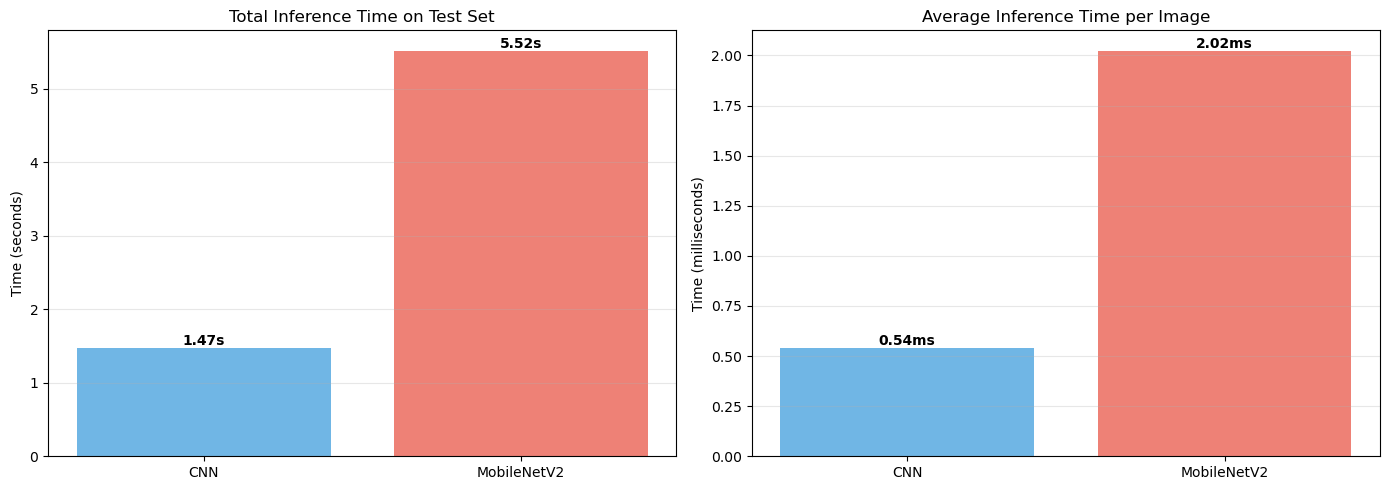

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total inference time
axes[0].bar(['CNN', 'MobileNetV2'], 
           [cnn_results['inference_time'], mobilenet_results['inference_time']], 
           color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Total Inference Time on Test Set')
axes[0].grid(axis='y', alpha=0.3)

for i, (name, time_val) in enumerate([('CNN', cnn_results['inference_time']), 
                                      ('MobileNetV2', mobilenet_results['inference_time'])]):
    axes[0].text(i, time_val, f'{time_val:.2f}s', 
                ha='center', va='bottom', fontweight='bold')

axes[1].bar(['CNN', 'MobileNetV2'], 
           [cnn_results['avg_time_per_image'], mobilenet_results['avg_time_per_image']], 
           color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_ylabel('Time (milliseconds)')
axes[1].set_title('Average Inference Time per Image')
axes[1].grid(axis='y', alpha=0.3)

for i, (name, time_val) in enumerate([('CNN', cnn_results['avg_time_per_image']), 
                                      ('MobileNetV2', mobilenet_results['avg_time_per_image'])]):
    axes[1].text(i, time_val, f'{time_val:.2f}ms', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/inference_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

speedup = mobilenet_results['avg_time_per_image'] / cnn_results['avg_time_per_image']

## Model Complexity Comparison

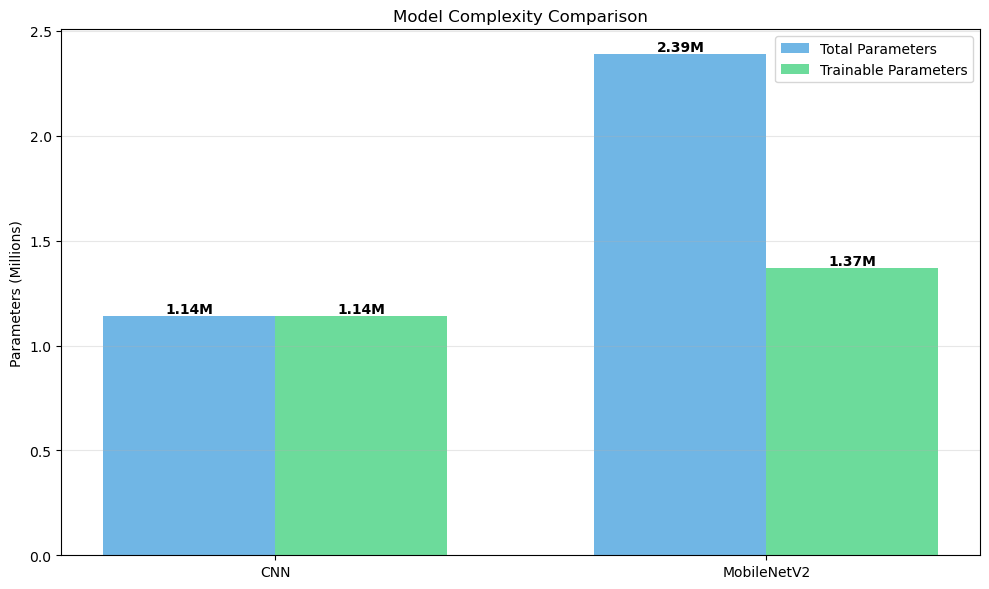

CNN: 1,142,082 parameters
MobileNetV2: 2,388,354 total parameters (1,370,562 trainable)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['CNN', 'MobileNetV2']
total_params = [cnn_params / 1e6, mobilenet_params / 1e6] 
trainable_params = [cnn_params / 1e6, mobilenet_trainable / 1e6]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, total_params, width, label='Total Parameters', 
               color='#3498db', alpha=0.7)
bars2 = ax.bar(x + width/2, trainable_params, width, label='Trainable Parameters', 
               color='#2ecc71', alpha=0.7)

ax.set_ylabel('Parameters (Millions)')
ax.set_title('Model Complexity Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}M',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/model_complexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"CNN: {cnn_params:,} parameters")
print(f"MobileNetV2: {mobilenet_params:,} total parameters ({mobilenet_trainable:,} trainable)")

## Side-by-Side Prediction Examples

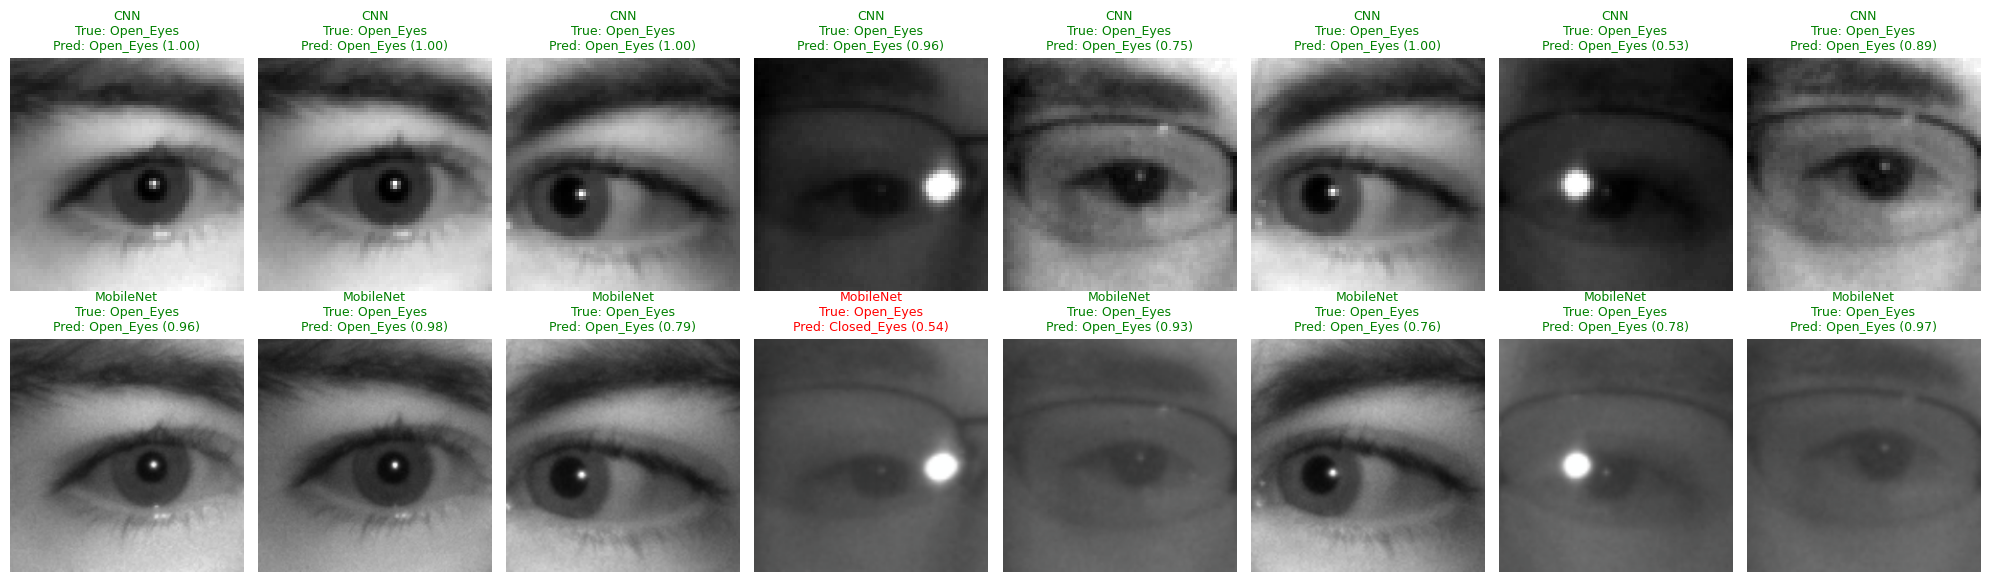

In [ ]:
import random

num_samples = 8
sample_indices = random.sample(range(len(test_paths)), num_samples)

fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))

for i, idx in enumerate(sample_indices):
    img_path = test_paths[idx]
    true_label = test_labels[idx]
    
    cnn_img, _ = cnn_test_dataset[idx]
    cnn_img_input = cnn_img.unsqueeze(0).to(device)
    with torch.no_grad():
        cnn_output = cnn_model(cnn_img_input)
        cnn_pred = cnn_output.argmax(dim=1).item()
        cnn_prob = torch.softmax(cnn_output, dim=1)[0][cnn_pred].item()
    
    mobilenet_img, _ = mobilenet_test_dataset[idx]
    mobilenet_img_input = mobilenet_img.unsqueeze(0).to(device)
    with torch.no_grad():
        mobilenet_output = mobilenet_model(mobilenet_img_input)
        mobilenet_pred = mobilenet_output.argmax(dim=1).item()
        mobilenet_prob = torch.softmax(mobilenet_output, dim=1)[0][mobilenet_pred].item()
    
    cnn_img_display = cnn_img.squeeze().cpu().numpy()
    cnn_img_display = (cnn_img_display * 0.5) + 0.5  
    axes[0, i].imshow(cnn_img_display, cmap='gray')
    axes[0, i].axis('off')
    color = 'green' if cnn_pred == true_label else 'red'
    axes[0, i].set_title(f"CNN\nTrue: {classes[true_label]}\nPred: {classes[cnn_pred]} ({cnn_prob:.2f})", 
                        color=color, fontsize=9)
    
    mobilenet_img_display = mobilenet_img.permute(1, 2, 0).cpu().numpy()
    mobilenet_img_display = (mobilenet_img_display * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    mobilenet_img_display = np.clip(mobilenet_img_display, 0, 1)
    axes[1, i].imshow(mobilenet_img_display)
    axes[1, i].axis('off')
    color = 'green' if mobilenet_pred == true_label else 'red'
    axes[1, i].set_title(f"MobileNet\nTrue: {classes[true_label]}\nPred: {classes[mobilenet_pred]} ({mobilenet_prob:.2f})", 
                        color=color, fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/side_by_side_predictions.png', dpi=300, bbox_inches='tight')
plt.show()



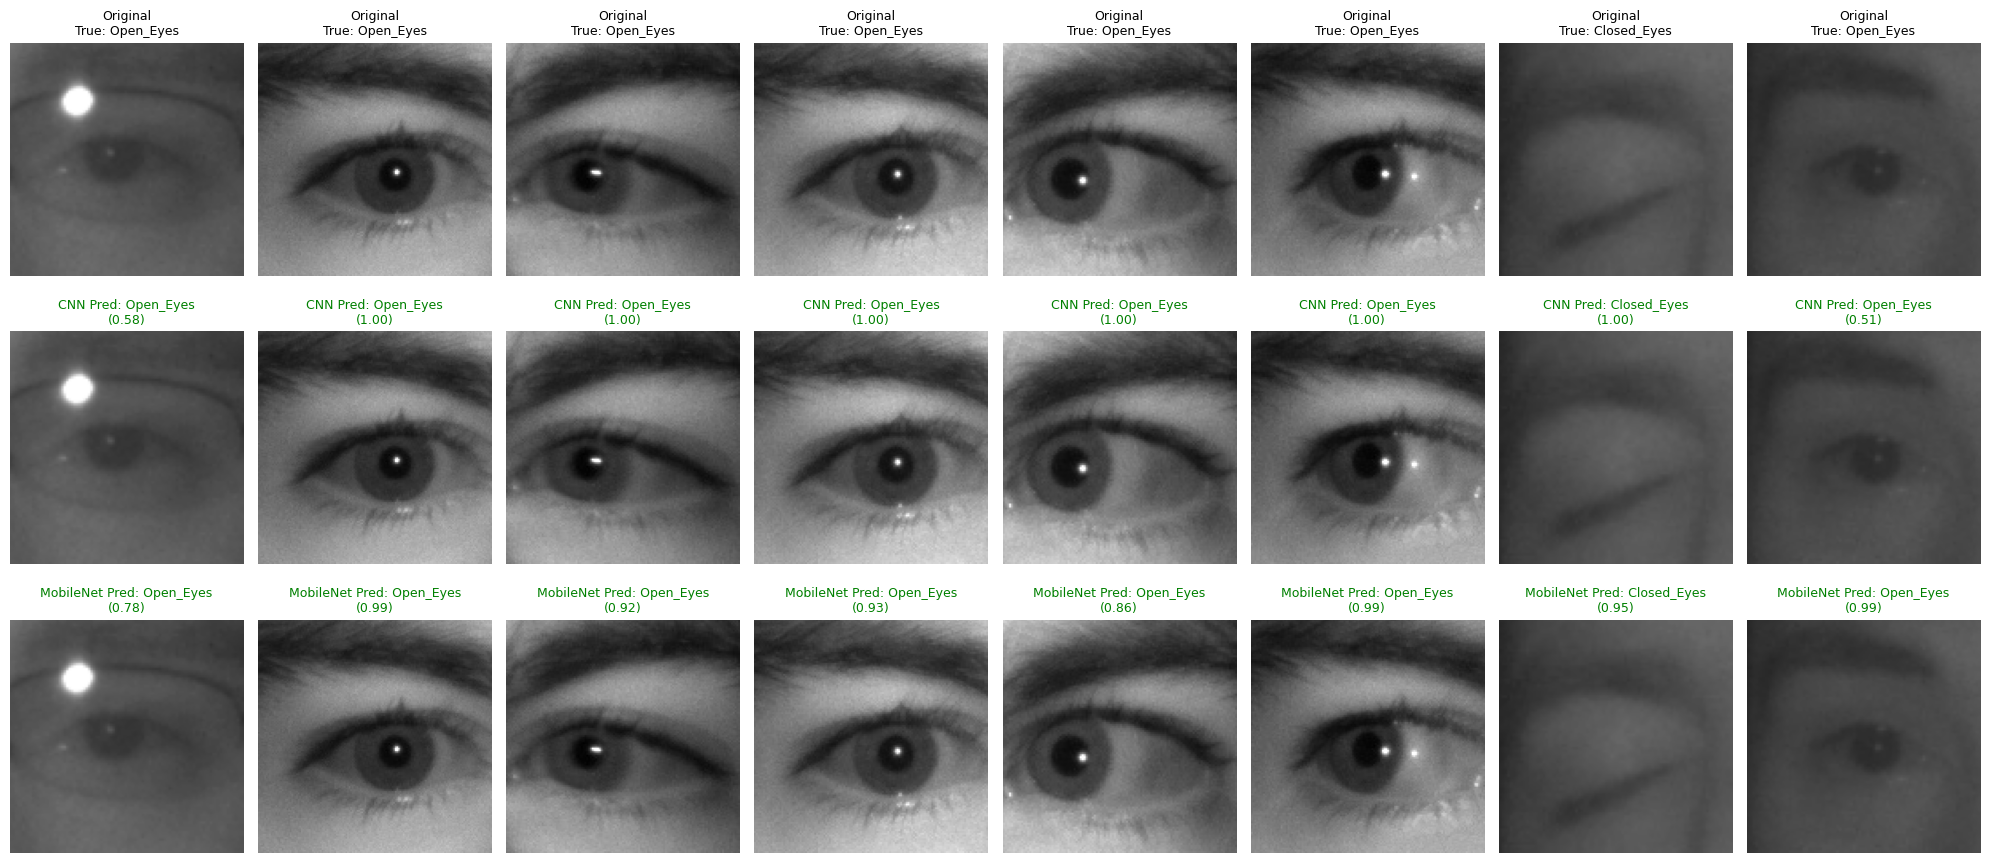

In [ ]:
import random

num_samples = 8
sample_indices = random.sample(range(len(test_paths)), num_samples)

fig, axes = plt.subplots(3, num_samples, figsize=(20, 9))

for i, idx in enumerate(sample_indices):
    img_path = test_paths[idx]
    true_label = test_labels[idx]
    
    original_img = Image.open(img_path).convert("RGB")
    
    cnn_img, _ = cnn_test_dataset[idx]
    cnn_img_input = cnn_img.unsqueeze(0).to(device)
    with torch.no_grad():
        cnn_output = cnn_model(cnn_img_input)
        cnn_pred = cnn_output.argmax(dim=1).item()
        cnn_prob = torch.softmax(cnn_output, dim=1)[0][cnn_pred].item()
    
    mobilenet_img, _ = mobilenet_test_dataset[idx]
    mobilenet_img_input = mobilenet_img.unsqueeze(0).to(device)
    with torch.no_grad():
        mobilenet_output = mobilenet_model(mobilenet_img_input)
        mobilenet_pred = mobilenet_output.argmax(dim=1).item()
        mobilenet_prob = torch.softmax(mobilenet_output, dim=1)[0][mobilenet_pred].item()
    
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original\nTrue: {classes[true_label]}", fontsize=9)
    
    color = 'green' if cnn_pred == true_label else 'red'
    axes[1, i].imshow(original_img) 
    axes[1, i].axis('off')
    axes[1, i].set_title(f"CNN Pred: {classes[cnn_pred]}\n({cnn_prob:.2f})", 
                        color=color, fontsize=9)
    
    color = 'green' if mobilenet_pred == true_label else 'red'
    axes[2, i].imshow(original_img)  
    axes[2, i].axis('off')
    axes[2, i].set_title(f"MobileNet Pred: {classes[mobilenet_pred]}\n({mobilenet_prob:.2f})", 
                        color=color, fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/comparison_on_original_images.png', dpi=300, bbox_inches='tight')
plt.show()